In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
with open("fine_mb_sweep.json", "r") as f:
    df = pd.DataFrame(json.load(f))
df.sort_values("run_id", inplace=True)
df

,run_id,bias_std_dev_scale,bias_height_fraction,perturbation_size,optimizer,found_minima,found_saddles,bias_count,energy_calls_at_each_min,force_calls_at_each_min
0,0,0.204481,0.20,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.0500535717...","[[0.2556700634906363, 0.4947039205036122], [0....",39,"[1, 353, 781]","[1, 353, 781]"
1,1,0.204481,0.20,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.0500439573...","[[-0.13986522263494194, 0.429078767754688], [-...",20,"[1, 204, 348]","[1, 204, 348]"
12,2,0.204481,0.20,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.0500439196...","[[0.17519306413286712, 0.11124398903016144], [...",39,"[1, 253, 780]","[1, 253, 780]"
23,3,0.204481,0.20,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.0500654769...","[[-0.16715691796781618, 0.4563803572313845], [...",21,"[1, 226, 360]","[1, 226, 360]"
34,4,0.204481,0.20,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.0500591103...","[[0.0011985959120424106, 0.47857839747946224],...",24,"[1, 201, 467]","[1, 201, 467]"
...,...,...,...,...,...,...,...,...,...,...
95,95,0.119581,0.02,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.0500108618...","[[0.2195251448074401, 0.2849800078912225], [-0...",1327,"[1, 21693, 149188]","[1, 21693, 149188]"
96,96,0.119581,0.02,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.0500107954...","[[0.20806869018905655, 0.30533267878121195], [...",1374,"[1, 26763, 156340]","[1, 26763, 156340]"
97,97,0.119581,0.02,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.0500107876...","[[0.1983664267051944, 0.2961266686749119], [-0...",1386,"[1, 23177, 155282]","[1, 23177, 155282]"
98,98,0.119581,0.02,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.0500108524...","[[0.19352321476020093, 0.2804720666370072], [-...",1321,"[1, 20747, 147755]","[1, 20747, 147755]"


In [14]:
import numpy as np
import pandas as pd
import json

# --- Load Known Potential ---
from ca_abc.potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()
known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

# --- Utilities ---
def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

def l2_closest(x, candidates):
    """Return the candidate closest to x (Euclidean norm) and its index."""
    dists = [np.linalg.norm(x - y) for y in candidates]
    idx = np.argmin(dists)
    return candidates[idx], idx

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

# --- Main Loop ---
rows = []

for idx, row in df.iterrows():
    # Deduplicate structures
    seed_saddles = row['found_saddles']
    seed_minima = row['found_minima']
    unique_saddles = list({tuple(s) for s in seed_saddles})
    unique_minima = list({tuple(m) for m in seed_minima})

    # Errors to known points
    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in unique_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in unique_minima]

    # Parse force and energy call lists safely
    force_calls_list = row['force_calls_at_each_min']
    energy_calls_list = row['energy_calls_at_each_min']

    if isinstance(force_calls_list, str):
        try:
            force_calls_list = json.loads(force_calls_list)
        except json.JSONDecodeError:
            force_calls_list = []

    if isinstance(energy_calls_list, str):
        try:
            energy_calls_list = json.loads(energy_calls_list)
        except json.JSONDecodeError:
            energy_calls_list = []

    force_calls_at_final_min = force_calls_list[-1] if force_calls_list else np.nan
    energy_calls_at_final_min = energy_calls_list[-1] if energy_calls_list else np.nan

    # Per-step breakdowns
    per_min_force_calls = cumulative_to_diffs(force_calls_list) if force_calls_list else []

    # --- Barrier error computation ---
    barrier_error_0 = np.nan
    barrier_error_1 = np.nan

    if len(seed_minima) >= 2 and len(seed_saddles) >= 1:
        try:
            # Match minimum[0] with saddle[0]
            found_min_0 = seed_minima[0]
            found_sad_0 = seed_saddles[0]
            closest_known_min_0, _ = l2_closest(found_min_0, known_minima)
            closest_known_sad_0, _ = l2_closest(found_sad_0, known_saddles)
            true_barrier_0 = potential.potential(closest_known_sad_0) - potential.potential(closest_known_min_0)
            found_barrier_0 = potential.potential(found_sad_0) - potential.potential(found_min_0)
            barrier_error_0 = abs(found_barrier_0 - true_barrier_0)
            found_min_1 = seed_minima[1]
            closest_known_min_1, _ = l2_closest(found_min_1, known_minima)

            if len(seed_minima) == 3 and len(seed_saddles) == 2: 
                found_sad_1 = seed_saddles[1]
                closest_known_sad_1, _ = l2_closest(found_sad_1, known_saddles)
                true_barrier_1 = potential.potential(closest_known_sad_1) - potential.potential(closest_known_min_1)
                found_barrier_1 = potential.potential(found_sad_1) - potential.potential(found_min_1)
                barrier_error_1 = abs(found_barrier_1 - true_barrier_1)

        except Exception as e:
            print(f"[WARNING] Failed to compute barrier error for run {row['run_id']}: {e}")

    # --- Summary ---
    summary = {
        'run_id': row['run_id'],
        'saddle_error_list': saddle_errors,
        # 'saddle_error_mean': np.mean(saddle_errors),
        # 'saddle_error_stderr': standard_error(saddle_errors),
        # 'minima_error_mean': np.mean(minima_errors),
        # 'minima_error_stderr': standard_error(minima_errors),
        'bias_count': row['bias_count'],
        'num_minima': len(unique_minima),
        'num_saddles': len(unique_saddles),
        'force_calls_at_final_min': force_calls_at_final_min,
        'mean_force_calls_per_min': force_calls_at_final_min / len(unique_minima) if len(unique_minima) > 0 else np.nan,
        # 'stdv_force_calls_per_min': np.std(per_min_force_calls, ddof=1) if len(per_min_force_calls) > 1 else np.nan,
        # 'mean_force_calls_per_saddle': total_force_calls / len(unique_saddles) if len(unique_saddles) > 0 else np.nan,
        # 'stdv_force_calls_per_saddle': np.std(per_saddle_force_calls, ddof=1) if len(per_saddle_force_calls) > 1 else np.nan,
        'energy_calls_at_final_min': energy_calls_at_final_min,
        'bias_std_dev_scale': row['bias_std_dev_scale'],
        'bias_height_fraction': row['bias_height_fraction'],
        'bias_covariance': (0.55*row['bias_std_dev_scale'])**2,
        'bias_height': (38*row['bias_height_fraction']),
        'perturbation_size': round(row['perturbation_size'], 6),
        'optimizer': row['optimizer'],
        'barrier_error_0': barrier_error_0,
        'barrier_error_1': barrier_error_1,
    }

    rows.append(summary)

# --- Final DataFrame ---
full_df = pd.DataFrame(rows)

# Preview
full_df


,run_id,saddle_error_list,bias_count,num_minima,num_saddles,force_calls_at_final_min,mean_force_calls_per_min,energy_calls_at_final_min,bias_std_dev_scale,bias_height_fraction,bias_covariance,bias_height,perturbation_size,optimizer,barrier_error_0,barrier_error_1
0,0,"[0.20628619561833486, 0.31834802033969417]",39,3,2,781,260.333333,781,0.204481,0.20,0.012648,7.60,0.005,Scipy,5.616813,12.483792
1,1,"[0.3777200058395759, 0.3205568062137161]",20,3,2,348,116.000000,348,0.204481,0.20,0.012648,7.60,0.005,Scipy,6.099548,18.908906
2,2,"[0.24745772096234514, 0.18553115686690624]",39,3,2,780,260.000000,780,0.204481,0.20,0.012648,7.60,0.005,Scipy,2.011322,15.537130
3,3,"[0.41331119417678086, 0.25352043961218845]",21,3,2,360,120.000000,360,0.204481,0.20,0.012648,7.60,0.005,Scipy,6.698103,13.587252
4,4,"[0.28122284407728865, 0.35188026713499304]",24,3,2,467,155.666667,467,0.204481,0.20,0.012648,7.60,0.005,Scipy,8.001500,21.359112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,"[0.010661824933409872, 0.04591389640546569]",1327,3,2,149188,49729.333333,149188,0.119581,0.02,0.004326,0.76,0.005,FIRE,0.039739,0.185903
96,96,"[0.013111095906141953, 0.017299490785537094]",1374,3,2,156340,52113.333333,156340,0.119581,0.02,0.004326,0.76,0.005,FIRE,0.057896,0.070460
97,97,"[0.014464715204372947, 0.017612724888385778]",1386,3,2,155282,51760.666667,155282,0.119581,0.02,0.004326,0.76,0.005,FIRE,0.006046,0.006683
98,98,"[0.006657713900564915, 0.022721488133129047]",1321,3,2,147755,49251.666667,147755,0.119581,0.02,0.004326,0.76,0.005,FIRE,0.129119,0.006995


In [15]:
import pandas as pd
import numpy as np

# Define the grouping columns
group_cols = ['bias_height', 'bias_covariance', 'perturbation_size', 'optimizer']

# Columns that should not be aggregated via mean/stderr because they're constant in group
pass_through_cols = ['bias_std_dev_scale', 'bias_height_fraction']

# Define numeric columns to aggregate
agg_cols = [col for col in full_df.columns 
            if col not in ['run_id', 'saddle_error_list'] + group_cols + pass_through_cols]

# Define custom aggregation functions
def safe_mean(x):
    return x.dropna().mean() if not x.dropna().empty else np.nan

def safe_stderr(x):
    return x.dropna().std(ddof=1) / np.sqrt(len(x.dropna())) if len(x.dropna()) > 1 else np.nan if not x.dropna().empty else np.nan

# Aggregation dict for mean and stderr
agg_dict = {col: [safe_mean, safe_stderr] for col in agg_cols}

# Add one-value passthrough columns (take first since they are constant within group)
for col in pass_through_cols:
    agg_dict[col] = 'first'

# Perform aggregation
grouped = full_df.groupby(group_cols).agg(agg_dict)

# Flatten MultiIndex columns
grouped.columns = [
    f'{col[0]}_mean' if col[1] == 'safe_mean' else 
    f'{col[0]}_stderr' if col[1] == 'safe_stderr' else 
    col[0]  # for 'first'
    for col in grouped.columns
]
grouped = grouped.reset_index()

# STEP 1 — Count how many runs in each group had valid barrier_error_0 and barrier_error_1
n_barrier_counts = full_df.groupby(group_cols).agg({
    'barrier_error_0': lambda x: x.notna().sum(),
    'barrier_error_1': lambda x: x.notna().sum(),
}).rename(columns={
    'barrier_error_0': 'n_0',
    'barrier_error_1': 'n_1'
}).reset_index()

# STEP 2 — Merge the counts into the grouped DataFrame
grouped = grouped.merge(n_barrier_counts, on=group_cols, how='left')

# STEP 3 & 4 — Compute weighted mean and stderr with fallback for missing barrier 0 or 1
n_total = grouped['n_0'] + grouped['n_1']

# Avoid division by zero
grouped['barrier_error_mean'] = np.where(
    n_total > 0,
    (
        grouped['barrier_error_0_mean'].fillna(0) * grouped['n_0'] +
        grouped['barrier_error_1_mean'].fillna(0) * grouped['n_1']
    ) / n_total,
    np.nan
)

grouped['barrier_error_stderr'] = np.where(
    n_total > 0,
    np.sqrt(
        (
            (grouped['n_0']**2 * grouped['barrier_error_0_stderr'].fillna(0)**2) +
            (grouped['n_1']**2 * grouped['barrier_error_1_stderr'].fillna(0)**2)
        ) / n_total**2
    ),
    np.nan
)



# Final result
grouped.columns


Index(['bias_height', 'bias_covariance', 'perturbation_size', 'optimizer',
       'bias_count_mean', 'bias_count_stderr', 'num_minima_mean',
       'num_minima_stderr', 'num_saddles_mean', 'num_saddles_stderr',
       'force_calls_at_final_min_mean', 'force_calls_at_final_min_stderr',
       'mean_force_calls_per_min_mean', 'mean_force_calls_per_min_stderr',
       'energy_calls_at_final_min_mean', 'energy_calls_at_final_min_stderr',
       'barrier_error_0_mean', 'barrier_error_0_stderr',
       'barrier_error_1_mean', 'barrier_error_1_stderr', 'bias_std_dev_scale',
       'bias_height_fraction', 'n_0', 'n_1', 'barrier_error_mean',
       'barrier_error_stderr'],
      dtype='object')

In [16]:
grouped_for_pareto = grouped[~grouped['barrier_error_mean'].isna()]

In [17]:
grouped_for_pareto.iloc[0]

bias_height                                 0.76
bias_covariance                         0.004326
perturbation_size                          0.005
optimizer                                   FIRE
bias_count_mean                           1339.6
bias_count_stderr                      10.365756
num_minima_mean                              3.0
num_minima_stderr                            0.0
num_saddles_mean                             2.0
num_saddles_stderr                           0.0
force_calls_at_final_min_mean           151414.7
force_calls_at_final_min_stderr      1445.580883
mean_force_calls_per_min_mean       50471.566667
mean_force_calls_per_min_stderr       481.860294
energy_calls_at_final_min_mean          151414.7
energy_calls_at_final_min_stderr     1445.580883
barrier_error_0_mean                    0.043123
barrier_error_0_stderr                  0.012998
barrier_error_1_mean                    0.091742
barrier_error_1_stderr                  0.035914
bias_std_dev_scale  

Elbow Point:
bias_height                            3.527616
bias_covariance                        0.012648
perturbation_size                         0.005
optimizer                                  FIRE
bias_count_mean                           117.2
bias_count_stderr                      9.551963
num_minima_mean                             3.0
num_minima_stderr                           0.0
num_saddles_mean                            2.0
num_saddles_stderr                          0.0
force_calls_at_final_min_mean           12711.6
force_calls_at_final_min_stderr     1098.561658
mean_force_calls_per_min_mean            4237.2
mean_force_calls_per_min_stderr      366.187219
energy_calls_at_final_min_mean          12711.6
energy_calls_at_final_min_stderr    1098.561658
barrier_error_0_mean                   0.273042
barrier_error_0_stderr                 0.084161
barrier_error_1_mean                   0.058118
barrier_error_1_stderr                 0.023309
bias_std_dev_scale         

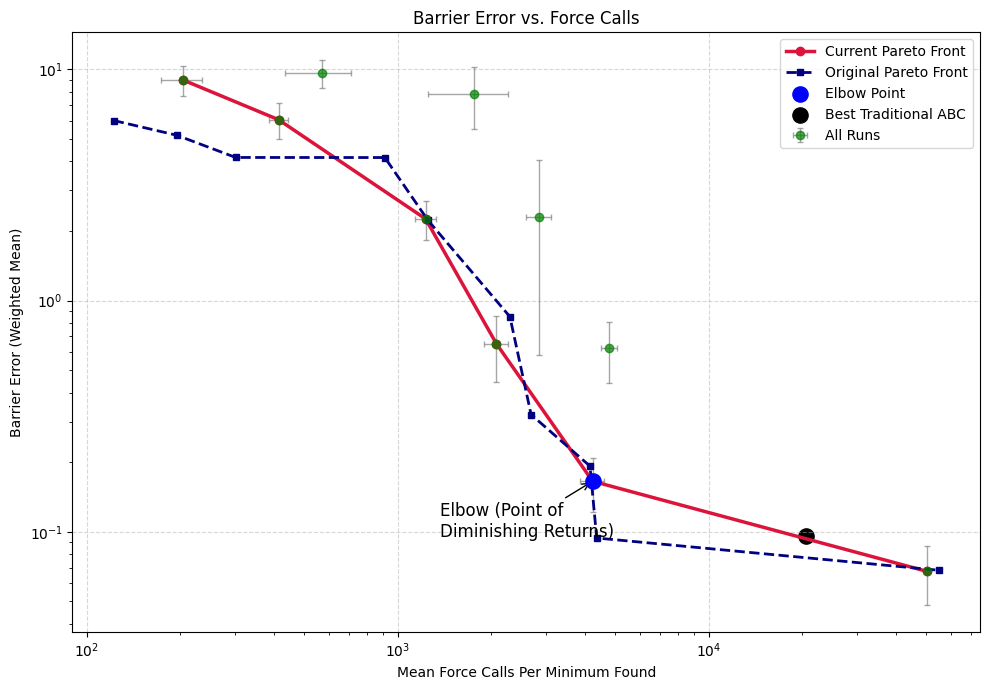

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract x and y values
x = np.array(grouped_for_pareto['mean_force_calls_per_min_mean'])
y = np.array(grouped_for_pareto['barrier_error_mean'])
xerr = np.array(grouped_for_pareto['mean_force_calls_per_min_stderr'])
yerr = np.array(grouped_for_pareto['barrier_error_stderr'])

def is_pareto_efficient(costs):
    """Return a boolean array indicating Pareto-efficient points."""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

def find_elbow_point_loglog(x, y):
    """Find elbow on log-log transformed points."""
    log_x = np.log10(x)
    log_y = np.log10(y)
    start = np.array([log_x[0], log_y[0]])
    end = np.array([log_x[-1], log_y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for lx, ly in zip(log_x, log_y):
        point_vec = np.array([lx, ly]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([lx, ly]) - proj_point)
        distances.append(dist)

    return np.argmax(distances)

# Build costs array for Pareto analysis
costs = np.vstack((x, y)).T
pareto_mask = is_pareto_efficient(costs)
pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort for consistent plotting
sort_idx = np.argsort(pareto_x)
pareto_x = pareto_x[sort_idx]
pareto_y = pareto_y[sort_idx]

# Find elbow
elbow_idx = find_elbow_point_loglog(pareto_x, pareto_y)
print("Elbow Point:")
print(grouped_for_pareto[pareto_mask].iloc[sort_idx[elbow_idx]])

# Load original Pareto front from JSON
og_pareto = pd.read_json("pareto_runs.json", orient="records")
og_x = np.array(og_pareto["mean_force_calls_per_min_mean"])
og_y = np.array(og_pareto["barrier_error_mean"])

# Optional: sort for smooth curve
og_sort_idx = np.argsort(og_x)
og_x = og_x[og_sort_idx]
og_y = og_y[og_sort_idx]

# --- Plotting ---
plt.figure(figsize=(10, 7))

# All runs
plt.errorbar(
    x, y,
    xerr=xerr, yerr=yerr,
    fmt='o', color='green', alpha=0.7, label='All Runs',
    ecolor='gray', elinewidth=1, capsize=2
)

# Current Pareto front
plt.plot(pareto_x, pareto_y, 'o-', color='crimson', linewidth=2.5, markersize=6, label='Current Pareto Front')

# Original Pareto front
plt.plot(og_x, og_y, 's--', color='navy', linewidth=2.0, markersize=5, label='Original Pareto Front')

# Elbow point
plt.scatter(pareto_x[elbow_idx], pareto_y[elbow_idx], color='blue', s=120, zorder=5, label='Elbow Point')
plt.annotate(
    "Elbow (Point of \nDiminishing Returns)",
    xy=(pareto_x[elbow_idx], pareto_y[elbow_idx]),
    xytext=(-110, -40), textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, color='black'
)

# Optional: reference point
plt.scatter(20618.7, 0.096217, label="Best Traditional ABC", s=120, color='black')

# Plot formatting
plt.xlabel("Mean Force Calls Per Minimum Found")
plt.ylabel("Barrier Error (Weighted Mean)")
plt.title("Barrier Error vs. Force Calls")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="major", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Elbow Point:
bias_height                           4.556086
bias_covariance                       0.006186
perturbation_size                        0.005
optimizer                                Scipy
bias_count_mean                           84.1
bias_count_stderr                    20.123756
num_minima_mean                            3.0
num_minima_stderr                          0.0
num_saddles_mean                           2.0
num_saddles_stderr                         0.0
force_calls_at_final_min_mean           1717.0
force_calls_at_final_min_stderr     413.683857
mean_force_calls_per_min_mean       572.333333
mean_force_calls_per_min_stderr     137.894619
energy_calls_at_final_min_mean          1717.0
energy_calls_at_final_min_stderr    413.683857
barrier_error_0_mean                  4.502102
barrier_error_0_stderr                0.715425
barrier_error_1_mean                 14.856377
barrier_error_1_stderr                2.613684
bias_std_dev_scale                    0.142997


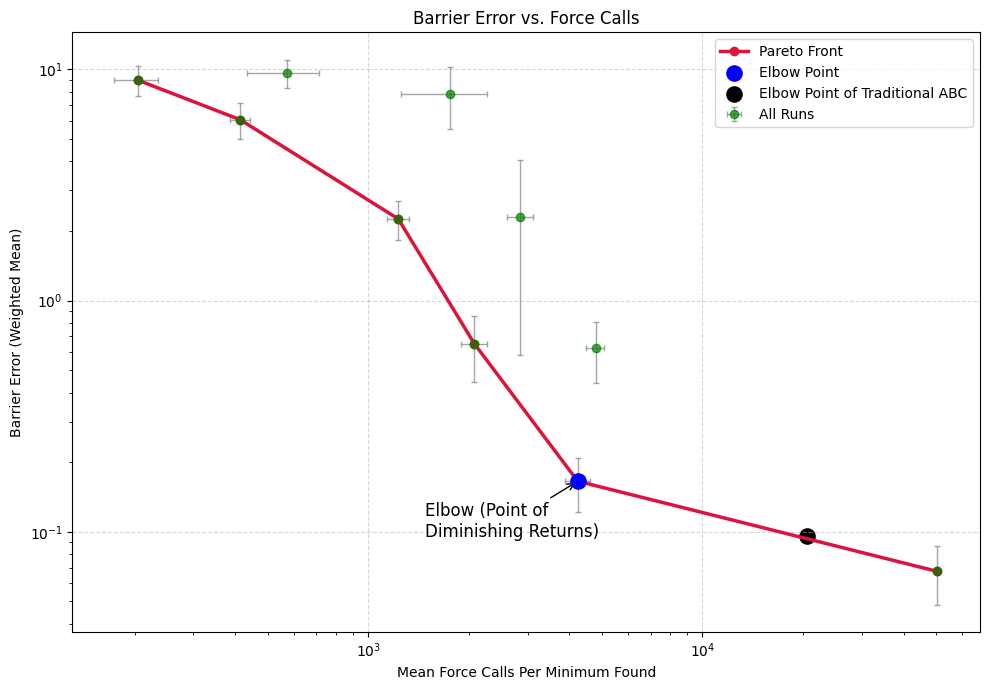

In [19]:
import matplotlib.pyplot as plt
import numpy as np

filtered_and_grouped_for_pareto = grouped_for_pareto[grouped_for_pareto['n_1']==10]

# Extract x and y values
x = np.array(filtered_and_grouped_for_pareto['mean_force_calls_per_min_mean'])
y = np.array(filtered_and_grouped_for_pareto['barrier_error_mean'])
xerr = np.array(filtered_and_grouped_for_pareto['mean_force_calls_per_min_stderr'])
yerr = np.array(filtered_and_grouped_for_pareto['barrier_error_stderr'])

def is_pareto_efficient(costs):
    """Return a boolean array indicating Pareto-efficient points."""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Remove points that are dominated
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

def find_elbow_point(x, y):
    """
    Find the elbow point on a 2D curve (x, y).
    x, y should be sorted along x-axis.
    Returns index of elbow point.
    """
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for xi, yi in zip(x, y):
        point_vec = np.array([xi, yi]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([xi, yi]) - proj_point)
        distances.append(dist)

    distances = np.array(distances)
    elbow_idx = np.argmax(distances)
    return elbow_idx

def find_elbow_point_loglog(x, y):
    """
    Find elbow on log-log transformed points.
    x, y must be positive.
    Returns index of elbow point.
    """
    log_x = np.log10(x)
    log_y = np.log10(y)
    start = np.array([log_x[0], log_y[0]])
    end = np.array([log_x[-1], log_y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for lx, ly in zip(log_x, log_y):
        point_vec = np.array([lx, ly]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([lx, ly]) - proj_point)
        distances.append(dist)

    distances = np.array(distances)
    elbow_idx = np.argmax(distances)
    return elbow_idx

# Build costs array for Pareto analysis (minimize both x and y)
costs = np.vstack((x, y)).T
pareto_mask = is_pareto_efficient(costs)
pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort Pareto front points by x for plotting
sort_idx = np.argsort(pareto_x)
pareto_x = pareto_x[sort_idx]
pareto_y = pareto_y[sort_idx]

# Find elbow point on Pareto front
# elbow_idx = find_elbow_point(pareto_x, pareto_y)
elbow_idx = find_elbow_point_loglog(pareto_x, pareto_y)
print("Elbow Point:")
print(grouped_for_pareto.iloc[elbow_idx])

# Log-log linear regression on Pareto front (optional)
log_x = np.log10(pareto_x)
log_y = np.log10(pareto_y)
m, b = np.polyfit(log_x, log_y, 1)
fit_log_x = np.linspace(log_x.min(), log_x.max(), 100)
fit_log_y = m * fit_log_x + b
fit_x = 10 ** fit_log_x
fit_y = 10 ** fit_log_y

# --- Plotting ---
plt.figure(figsize=(10, 7))

# Plot all points with error bars (comment out error bars easily)
plt.errorbar(
    x, y,
    xerr=xerr, yerr=yerr,
    fmt='o', color='green', alpha=0.7, label='All Runs',
    ecolor='gray', elinewidth=1, capsize=2
)
# To plot without error bars, comment out the above plt.errorbar() line and uncomment the below:
# plt.scatter(x, y, color='green', alpha=0.7, label='All Runs')

# Highlight Pareto front
plt.plot(pareto_x, pareto_y, 'o-', color='crimson', linewidth=2.5, markersize=6, label='Pareto Front')

# Highlight elbow point
plt.scatter(pareto_x[elbow_idx], pareto_y[elbow_idx], color='blue', s=120, zorder=5, label='Elbow Point')
plt.annotate(
    "Elbow (Point of \nDiminishing Returns)",
    xy=(pareto_x[elbow_idx], pareto_y[elbow_idx]),
    xytext=(-110, -40), textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, color='black'
)

# Optional: plot regression line on Pareto front
# plt.plot(fit_x, fit_y, '--', color='black', linewidth=2, label=f'Fit: slope = {m:.3f}')
plt.scatter(20618.7, 0.096217, label="Elbow Point of Traditional ABC", s=120, color='black')
# plt.scatter(grouped_for_pareto.iloc[0]['mean_force_calls_per_min_mean'], grouped_for_pareto.iloc[0]['barrier_error_mean'], color='black', s=120, label="Default Scaling", zorder=5)


# Labels and formatting
plt.xlabel("Mean Force Calls Per Minimum Found")
plt.ylabel("Barrier Error (Weighted Mean)")
plt.title("Barrier Error vs. Force Calls")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="major", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Note: we use this one, which filters out all combinations that did not successfully identify 3 minima and 2 saddles within 5000 bias placements every single time

KeyError: 'adaptive_height_scale'

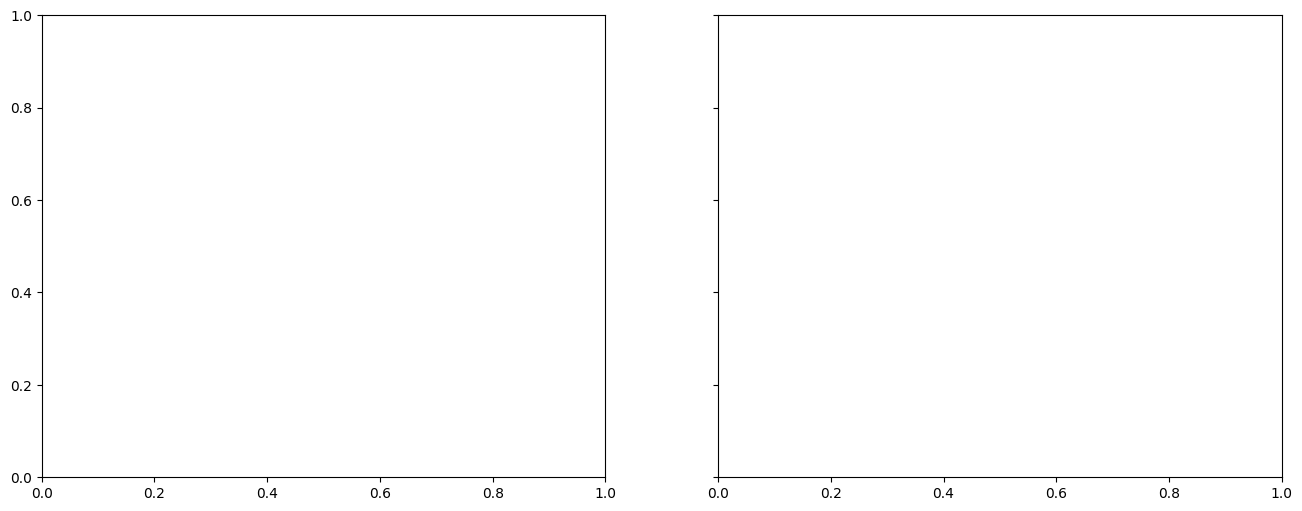

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assumes: grouped_for_pareto is already filtered to remove NaNs

# Define heatmap parameters
x_param = 'adaptive_cov_scale'
y_param = 'adaptive_height_scale'
metrics = ['barrier_error_mean', 'mean_force_calls_per_min_mean']
optimizers = ['FIRE']

# Create figure
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 6),
    sharex=True, sharey=True
)

for row_idx, optimizer in enumerate(optimizers):
    for col_idx, metric in enumerate(metrics):
        ax = axes[col_idx]

        # Filter for the optimizer
        df_opt = grouped_for_pareto[grouped_for_pareto['optimizer'] == optimizer]

        # Pivot table for heatmap
        heatmap_data = df_opt.pivot_table(
            index=y_param, columns=x_param, values=metric
        )

        # Sort axes numerically ascending
        heatmap_data = heatmap_data.sort_index(ascending=True).sort_index(axis=1, ascending=True)

        # Build annotation matrix with fallback message for NaNs
        annot_matrix = heatmap_data.copy().astype(object)

        for i in range(annot_matrix.shape[0]):
            for j in range(annot_matrix.shape[1]):
                val = annot_matrix.iloc[i, j]
                if pd.isna(val):
                    annot_matrix.iloc[i, j] = "Did not ID 2nd Min"
                else:
                    annot_matrix.iloc[i, j] = f"{val:.2g}"

        # Choose smaller font for crowded force plots
        annot_kws = {'size': 7} if 'force_calls' in metric else {'size': 9}
        annot_fontsize = 7 if 'force_calls' in metric else 8

        # Plot heatmap with custom annotation strings
        sns.heatmap(
            heatmap_data,
            ax=ax,
            cmap='viridis',
            cbar_kws={'label': metric.replace('_', ' ').title()},
            annot=annot_matrix,
            fmt='',  # Use string annotations as-is
            annot_kws=annot_kws,
            xticklabels=True, yticklabels=True
        )

        # Overlay custom annotations manually (including NaNs)
        for i in range(heatmap_data.shape[0]):
            for j in range(heatmap_data.shape[1]):
                val = heatmap_data.iloc[i, j]
                text = "Did not ID\n2nd Min" if pd.isna(val) else None
                ax.text(
                    j + 0.5, i + 0.5, text,
                    ha='center', va='center',
                    fontsize=annot_fontsize, color='black'
                )

        # Invert y-axis back to normal (bottom = low, top = high)
        ax.invert_yaxis()

        # Format tick labels to 3 decimal places
        ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
        ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5)
        ax.set_xticklabels([f"{v:.3f}" for v in heatmap_data.columns])
        ax.set_yticklabels([f"{v:.3f}" for v in heatmap_data.index])

        # Labels and title
        ax.set_title(f'{optimizer} — {metric.replace("_", " ").title()}')
        ax.set_xlabel('Bias Covariance')
        ax.set_ylabel('Bias Height')


plt.tight_layout()
plt.show()

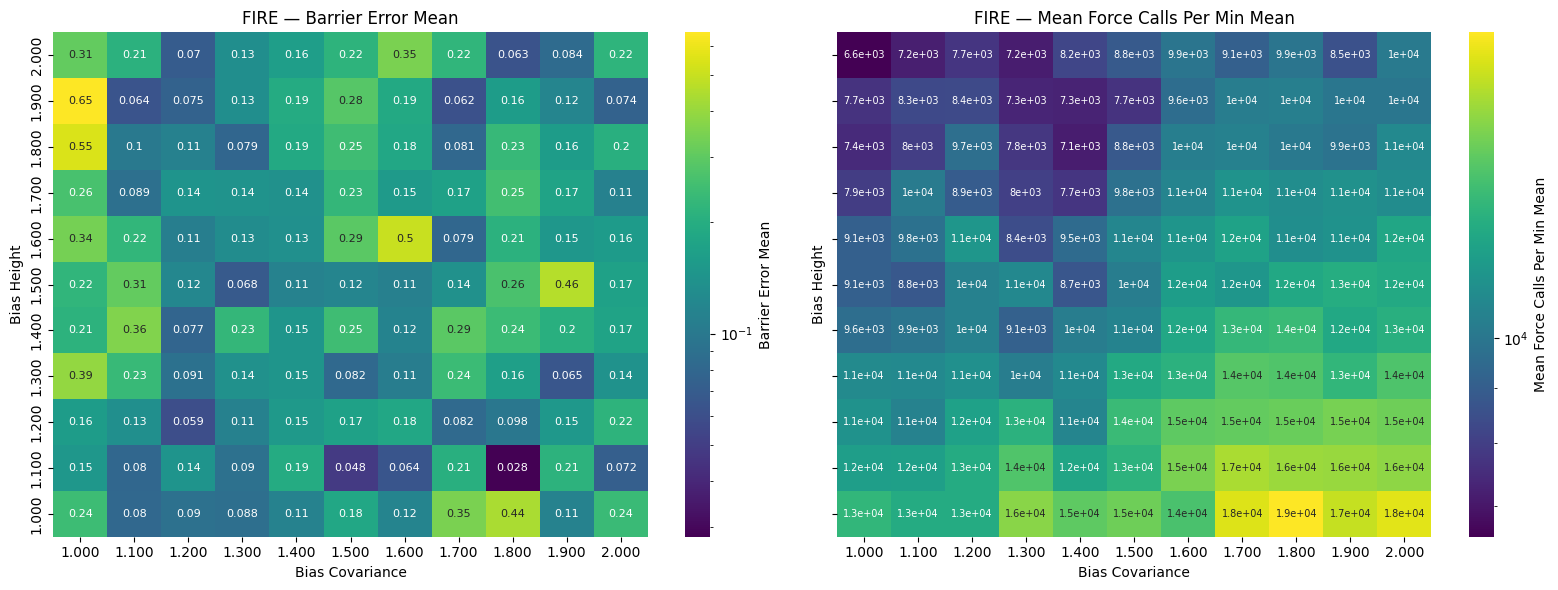

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

# Assumes: grouped_for_pareto is already filtered to remove NaNs

# Define heatmap parameters
x_param = 'adaptive_cov_scale'
y_param = 'adaptive_height_scale'
metrics = ['barrier_error_mean', 'mean_force_calls_per_min_mean']
optimizers = ['FIRE']

# Create figure
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 6),
    sharex=True, sharey=True
)

for row_idx, optimizer in enumerate(optimizers):
    for col_idx, metric in enumerate(metrics):
        ax = axes[col_idx]

        # Filter for the optimizer
        df_opt = grouped_for_pareto[grouped_for_pareto['optimizer'] == optimizer]

        # Pivot table for heatmap
        heatmap_data = df_opt.pivot_table(
            index=y_param, columns=x_param, values=metric
        )

        # Sort axes numerically ascending
        heatmap_data = heatmap_data.sort_index(ascending=True).sort_index(axis=1, ascending=True)

        # Build annotation matrix with fallback message for NaNs
        annot_matrix = heatmap_data.copy().astype(object)

        for i in range(annot_matrix.shape[0]):
            for j in range(annot_matrix.shape[1]):
                val = annot_matrix.iloc[i, j]
                if pd.isna(val):
                    annot_matrix.iloc[i, j] = "Did not ID 2nd Min"
                else:
                    annot_matrix.iloc[i, j] = f"{val:.2g}"

        # Choose smaller font for crowded force plots
        annot_fontsize = 7 if 'force_calls' in metric else 8

        # Determine vmin, vmax for LogNorm (ignore NaNs)
        values = heatmap_data.values.flatten()
        values = values[~np.isnan(values)]
        vmin = values[values > 0].min() if np.any(values > 0) else 1e-3  # fallback min
        vmax = values.max()

        # Plot heatmap with logarithmic color scale
        sns.heatmap(
            heatmap_data,
            ax=ax,
            cmap='viridis',
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cbar_kws={'label': metric.replace('_', ' ').title()},
            annot=annot_matrix,
            fmt='',  # Use string annotations as-is
            annot_kws={'size': annot_fontsize},
            xticklabels=True, yticklabels=True
        )

        # Overlay NaN annotations explicitly (to avoid overlap)
        for i in range(heatmap_data.shape[0]):
            for j in range(heatmap_data.shape[1]):
                val = heatmap_data.iloc[i, j]
                if pd.isna(val):
                    ax.text(
                        j + 0.5, i + 0.5, "Did not ID\n2nd Min",
                        ha='center', va='center',
                        fontsize=annot_fontsize, color='black'
                    )

        # Invert y-axis back to normal (bottom = low, top = high)
        ax.invert_yaxis()

        # Format tick labels to 3 decimal places
        ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
        ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5)
        ax.set_xticklabels([f"{v:.3f}" for v in heatmap_data.columns])
        ax.set_yticklabels([f"{v:.3f}" for v in heatmap_data.index])

        # Labels and title
        ax.set_title(f'{optimizer} — {metric.replace("_", " ").title()}')
        ax.set_xlabel('Bias Covariance')
        ax.set_ylabel('Bias Height')

plt.tight_layout()
plt.show()


To me, what this means is we need to do the following:
For each run on the original ABC's aggregated pareto front:
Run all combos of the following:
- With vs without adaptive perturbation
- a range of min cov factors [1,3]
- a range of max cov factors [1,3]
- a range of min height factors [1,3]
- a range of max height factors [1,3]
- 10 random runs 

there are 10 paretos 

this becomes 2*10*10*10*10*10 runs . . .= 2*10^5 per pareto is not tenable 

so fix all else at that pareto, and do a sweep
(2+10+10+10+10)*10 = 420 per pareto is still too much really
Pick 3 - fastest, most accurate, and elbow 

or 
sweep 
(2+10*10+10*10)*10 = 2020 on just the fixed best pareto 

why not do both? Start with the latter, and then do the former

or just do the latter for the elbow and do the former for the other 2, for a total of 
2860 runs 



or could prioritize accuracy, noting the speedup but risk present with ca-abc and how we should never actually need a min factor that matters 
take the most accurate run from abc and see what happens with this sweep like you did for the pareto run before
- only sample a max factor, keeping the min set to default 

-and sample the fastest run only allowing biases to shrink dynamically 



1. Whole pareto frontier with curvature-adaptive perturbation allowed *  
2. most accurate run with growing only * 
3. elbow run with more variation allowed (independent min and max)
4. fastest run with shrinking only 